## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

### Monotonic Weight Unit

In [2]:
class MELU(torch.nn.Module): # alpha(max(0,w) + min(1,exp(w))) - b
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(MELU, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.zeros(self.weights.shape)
        monotonic_weights[self.weights >= 0] = self.weights[self.weights >= 0]
        monotonic_weights[self.weights < 0] = torch.exp(self.weights[self.weights < 0])
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

class SOFTPLUS(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(SOFTPLUS, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = nn.Softplus()(self.weights)
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

class ExU(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(ExU, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.exp(self.weights)
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

class ABS(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(ABS, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.abs(self.weights)
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

class SQUARE(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(SQUARE, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.square(self.weights)
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

class SQRT(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(SQRT, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.sqrt(torch.abs(self.weights))
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

class LIN(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(LIN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = self.weights
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

## Model Architecture

In [3]:
class MELU_ELU_NN(nn.Module):
    def __init__(self):
        super(MELU_ELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(MELU(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(MELU(in_features, out_features))
        layers.append(MELU(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ELU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ELU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ELU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ELU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ELU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ELU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [4]:
class SOFTPLUS_NN(nn.Module):
    def __init__(self):
        super(SOFTPLUS_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(SOFTPLUS(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(SOFTPLUS(in_features, out_features))
        layers.append(SOFTPLUS(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.Softplus()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.Softplus()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.Softplus()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.Softplus()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.Softplus()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.Softplus()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [5]:
class SOFTPLUS_RELU_NN(nn.Module):
    def __init__(self):
        super(SOFTPLUS_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(SOFTPLUS(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(SOFTPLUS(in_features, out_features))
        layers.append(SOFTPLUS(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [6]:
class ABS_RELU_NN(nn.Module):
    def __init__(self):
        super(ABS_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(ABS(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(ABS(in_features, out_features))
        layers.append(ABS(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [7]:
class SQUARE_RELU_NN(nn.Module):
    def __init__(self):
        super(SQUARE_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(SQUARE(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(SQUARE(in_features, out_features))
        layers.append(SQUARE(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [8]:
class SQRT_RELU_NN(nn.Module):
    def __init__(self):
        super(SQRT_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(SQRT(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(SQRT(in_features, out_features))
        layers.append(SQRT(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [9]:
class LIN_RELU_NN(nn.Module):
    def __init__(self):
        super(LIN_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(LIN(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(LIN(in_features, out_features))
        layers.append(LIN(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [1,0] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [10]:
class MELU_RELU_NN(nn.Module):
    def __init__(self):
        super(MELU_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(MELU(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(MELU(in_features, out_features))
        layers.append(MELU(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [12]:
class ExU_RELU_NN(nn.Module):
    def __init__(self):
        super(ExU_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 30
        hidden_sizes = [self._num_units] + [30,30]
        layers = []
        layers.append(ExU(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(ExU(in_features, out_features))
        layers.append(ExU(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [83]:
class ABS_RELU_N_NN(nn.Module):
    def __init__(self):
        super(ABS_RELU_N_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 10
        hidden_sizes = [self._num_units] + [10]
        layers = []
        layers.append(ABS(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(ABS(in_features, out_features))
        layers.append(ABS(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)

    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0,0] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            # outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            # result_list = torch.tensor([])
            # result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            # result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            # temp_list = torch.zeros(outputs_list[2].shape)
            # temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            # temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            # result_list = torch.cat([result_list,temp_list],axis=1)
            # outputs = result_list
            outputs = nn.ReLU()(outputs)
            outputs = torch.clamp(outputs, 0, 1)
            # print(f"{layer_i} layer :", outputs)
        outputs = self.model[-1](outputs)
        # print(outputs)
        return outputs

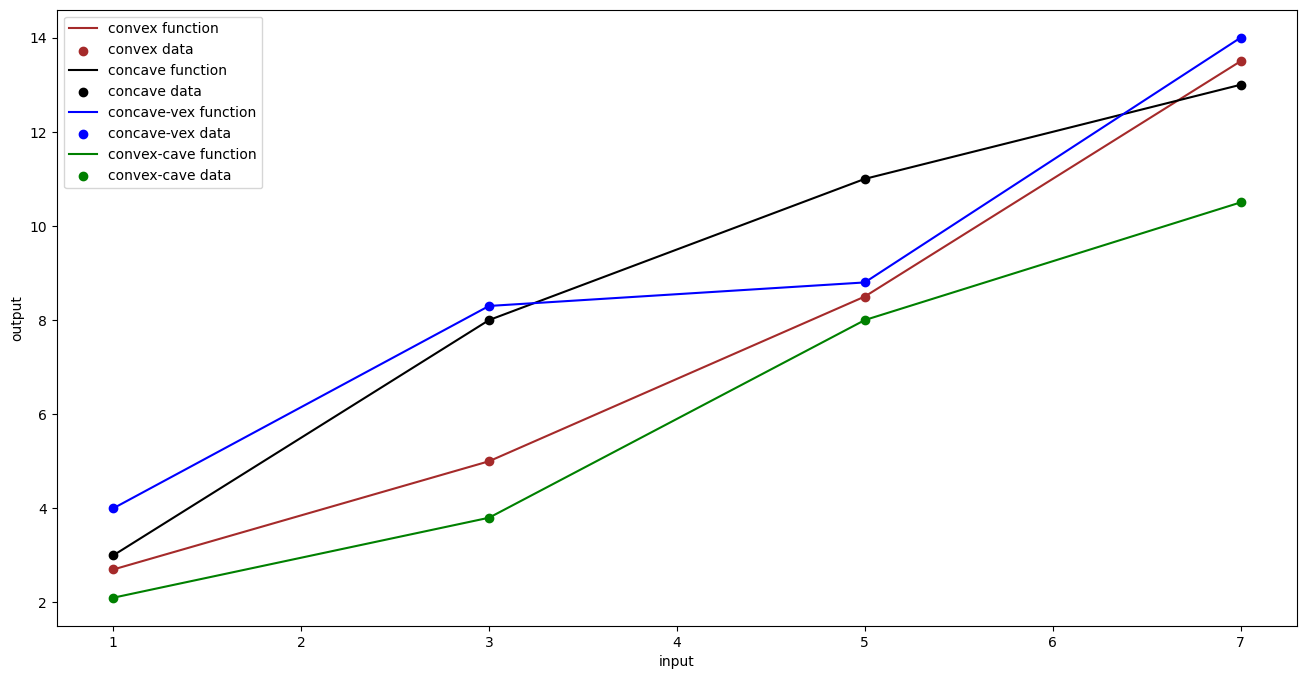

In [84]:
plt.figure(figsize=(16,8))
concave_a = torch.tensor([[1.], [3.], [5.], [7.]]).type(torch.float32)
concave_b = torch.tensor([[2.+1.],[7.+1.],[10.+1.],[12.+1.]]).type(torch.float32)
convex_a = torch.tensor([[1.], [3.], [5.], [7.]]).type(torch.float32)
convex_b = torch.tensor([[2.7],[4.+1.],[8.5],[13.5]]).type(torch.float32)
concavevex_a = torch.tensor([[1.], [3.], [5.], [7.]]).type(torch.float32)
concavevex_b = torch.tensor([[4.],[8.3],[8.8],[14]]).type(torch.float32)
convexcave_a = torch.tensor([[1.], [3.], [5.], [7.]]).type(torch.float32)
convexcave_b = torch.tensor([[2.1],[3.8],[8.],[10.5]]).type(torch.float32)
plt.plot(convex_a,convex_b,c='brown', label='convex function',zorder=1)
plt.scatter(convex_a,convex_b,c='brown', label='convex data',zorder=5)
plt.plot(concave_a,concave_b, c='black', label='concave function',zorder=2)
plt.scatter(concave_a,concave_b,c='black', label='concave data',zorder=6)
plt.plot(concavevex_a,concavevex_b, c='blue', label='concave-vex function',zorder=3)
plt.scatter(concavevex_a,concavevex_b,c='blue', label='concave-vex data',zorder=7)
plt.plot(convexcave_a,convexcave_b, c='green', label='convex-cave function',zorder=4)
plt.scatter(convexcave_a,convexcave_b,c='green', label='convex-cave data',zorder=8)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()

In [92]:
dataset = [[convex_a, convex_b]]#, [concave_a, concave_b],[concavevex_a, concavevex_b],[convexcave_a, convexcave_b]]
max_num = 2
min_num = 1
for i in range(min_num,max_num):
    exec(f"loss_log{i} = [[0,0,0,0] for j in range(50)]")
    exec(f"model_list{i} = []")
for data_i in range(len(dataset)):
    a = dataset[data_i][0]
    b = dataset[data_i][1]

    model1, model2, model3, model4, model5, model6, model7, model8, model9 = MELU_ELU_NN(), SOFTPLUS_RELU_NN(), ABS_RELU_NN(), SQUARE_RELU_NN(), SQRT_RELU_NN(), LIN_RELU_NN(), MELU_RELU_NN(), ExU_RELU_NN(), ABS_RELU_N_NN()
    for i in range(min_num,max_num):
        exec(f"model{i}.train()")
        exec(f"optimizer{i} = optim.Adam(model{i}.parameters(), lr=0.1)")
    
    
    for i in range(min_num,max_num):
        log_i = 0
        for epoch in (range(5000)):
            exec(f"optimizer{i}.zero_grad()")
            exec(f"loss{i} = torch.nn.functional.mse_loss(model{i}(a), b)")
            exec(f"loss{i}.backward()")
            exec(f"optimizer{i}.step()")
            
            if epoch % 200 == 199:
                exec(f"loss_log{i}[log_i][data_i] = loss{i}.detach().item()")
                print(eval(f"loss{i}.detach().item()"))
                log_i += 1
    for i in range(min_num,max_num):
        exec(f"model_list{i}.append(model{i})")

159.33358764648438
114.69561004638672
81.08177947998047
55.89313507080078
36.655147552490234
23.261959075927734
13.774828910827637
10.192152976989746
8.274499893188477
4.741363525390625
2.368595838546753
1.2124310731887817
1.348086953163147
0.5239540338516235
0.19779536128044128
0.11718407273292542
0.06628964096307755
0.04225843772292137
0.03207016363739967
0.01679045893251896
0.009107082150876522
0.004572958219796419
0.0020941291004419327
0.0008613549289293587


KeyboardInterrupt: 

In [74]:
torch.abs(model9.model[3].weights).sum()

tensor(7.8372, grad_fn=<SumBackward0>)

In [70]:
model9.model

ModuleList(
  (0): ABS(in_features=1, out_features=30)
  (1-2): 2 x ABS(in_features=30, out_features=30)
  (3): ABS(in_features=30, out_features=1)
)

In [71]:
model9(torch.tensor([[1000.]]))

0 layer : tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       grad_fn=<ClampBackward1>)
1 layer : tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       grad_fn=<ClampBackward1>)
2 layer : tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       grad_fn=<ClampBackward1>)
tensor([[7.4250]], grad_fn=<SubBackward0>)


tensor([[7.4250]], grad_fn=<SubBackward0>)

In [24]:
colors = ['red','blue','orange','black','skyblue','yellow','pink','brown','gray']
model_name = ["MELU_ELU_NN", "SOFTPLUS_RELU_NN", "ABS_RELU_NN", "SQUARE_RELU_NN", "SQRT_RELU_NN", "LIN_RELU_NN", "MELU_RELU_NN", "ExU_RELU_NN","MELU_RELU_N_NN"]
title_name = ['convex function', 'concave function', 'concave-vex function', 'convex-cave function']
start_point = 20
for j in range(4):
    plt.figure(figsize=(12,6))
    for i in range(min_num,max_num):
        data = eval(f"loss_log{i}[start_point:,[j]]")
        plt.plot(range(start_point*200, (len(data)+start_point)*200, 200), data, c=colors[i-1], label=model_name[i-1])
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.title(title_name[j])
    plt.show()

plt.figure(figsize=(12,6))
for i in range(min_num,max_num):
    data = eval(f"np.mean(loss_log{i}[start_point:], axis=1)")
    plt.plot(range(start_point*200, (len(data)+start_point)*200, 200), data, c=colors[i-1], label=model_name[i-1])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.title("Average Performance")
plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 1200x600 with 0 Axes>

IndexError: list index out of range

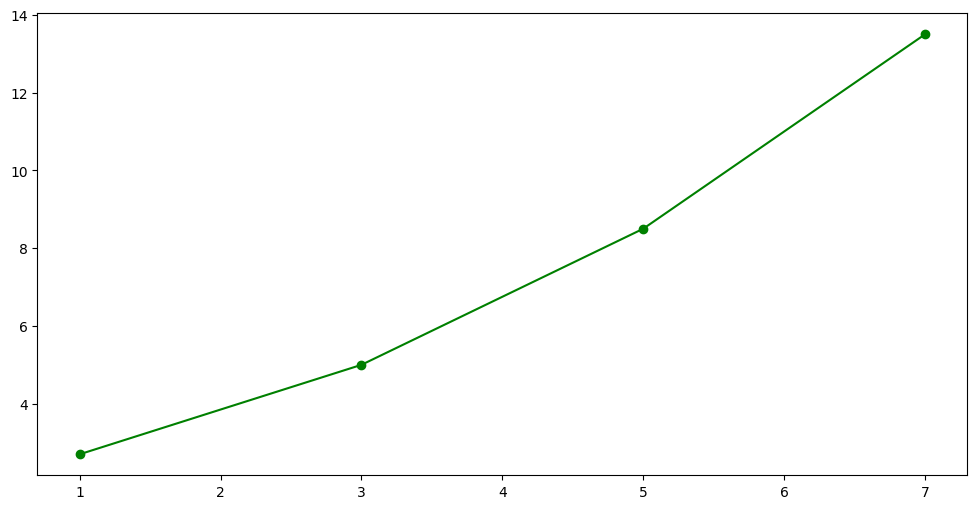

In [25]:
dataset = [[convex_a, convex_b]]#, [concave_a, concave_b],[concavevex_a, concavevex_b],[convexcave_a, convexcave_b]]
for idx in range(len(dataset)):
    plt.figure(figsize=(12,6))
    a = dataset[idx][0]
    b = dataset[idx][1]
    plt.plot(a,b, c='green', label='convex-cave function',zorder=1)
    plt.scatter(a,b,c='green', label='convex-cave data',zorder=2)
    for model_idx in range(min_num,max_num):
        exec(f"result{model_idx} = model_list{model_idx}[{idx}](torch.tensor([i/10 for i in range(10, 71)]).type(torch.float32).reshape(-1,1)).detach().numpy()")
        exec(f"plt.plot([i/10 for i in range(10, 71)],result{model_idx},c=colors[model_idx-1], label=model_name[model_idx-1],zorder=3)")
    plt.xlabel('input')
    plt.ylabel('output')
    plt.title(title_name[idx])
    plt.legend()
    plt.show()